## KaggleID: RyanGargett

In [ ]:
# Assuming google colab environment
!pip install optuna
!pip install optuna_integrations
!pip install xgboost
!pip install shap
!pip install pyale

In [337]:
RANDOM_SEED = 12345 # set for reproducible results

In [338]:
import pandas as pd

bleve_df = pd.read_csv("data/train.csv")
test_sample = pd.read_csv("data/test.csv")

In [442]:
bleve_df["sensor_pos_side"].values

['pos_2', 'pos_3', 'pos_3', 'pos_3', 'pos_4', ..., 'pos_4', 'pos_4', 'pos_5', 'pos_5', 'pos_5']
Length: 10000
Categories (5, object): ['pos_1', 'pos_2', 'pos_3', 'pos_4', 'pos_5']

In [339]:
bleve_df.head()

,ID,Tank Failure Pressure (bar),Liquid Ratio (%),Tank Width (m),Tank Length (m),Tank Height (m),BLEVE Height (m),Vapour Height (m),Vapour Temperature (K),Liquid Temperature (K),...,Status,Liquid Critical Pressure (bar),Liquid Boiling Temperature (K),Liquid Critical Temperature (K),Sensor ID,Sensor Position Side,Sensor Position x,Sensor Position y,Sensor Position z,Target Pressure (bar)
0,3203,7.3,0.4158,2.4,5.4,1.0,1.8,0.6,522.8,354.3,...,Superheated,37.9,-1,152.0,18,2,12.15,7.90,10.7,0.199929
1,3204,7.3,0.4158,2.4,5.4,1.0,1.8,0.6,522.8,354.3,...,Superheated,37.9,-1,152.0,19,3,12.50,-2.95,-1.9,0.435681
2,3205,7.3,0.4158,2.4,5.4,1.0,1.8,0.6,522.8,354.3,...,Superheated,37.9,-1,152.0,20,3,12.50,-2.95,4.4,0.264031
3,3206,7.3,0.4158,2.4,5.4,1.0,1.8,0.6,522.8,354.3,...,Superheated,37.9,-1,152.0,21,3,12.50,-2.95,10.7,0.270576
4,3207,7.3,0.4158,2.4,5.4,1.0,1.8,0.6,522.8,354.3,...,Superheated,37.9,-1,152.0,22,4,12.50,-2.70,11.0,0.204675


In [340]:
# remove unecessary columns to lower complexity

bleve_df.drop(columns=["ID", "Sensor ID"], inplace=True)
test_sample.drop(columns=["ID", "Sensor ID"], inplace=True)
bleve_df.head()

,Tank Failure Pressure (bar),Liquid Ratio (%),Tank Width (m),Tank Length (m),Tank Height (m),BLEVE Height (m),Vapour Height (m),Vapour Temperature (K),Liquid Temperature (K),Obstacle Distance to BLEVE (m),...,Obstacle Angle,Status,Liquid Critical Pressure (bar),Liquid Boiling Temperature (K),Liquid Critical Temperature (K),Sensor Position Side,Sensor Position x,Sensor Position y,Sensor Position z,Target Pressure (bar)
0,7.3,0.4158,2.4,5.4,1.0,1.8,0.6,522.8,354.3,11,...,13,Superheated,37.9,-1,152.0,2,12.15,7.90,10.7,0.199929
1,7.3,0.4158,2.4,5.4,1.0,1.8,0.6,522.8,354.3,11,...,13,Superheated,37.9,-1,152.0,3,12.50,-2.95,-1.9,0.435681
2,7.3,0.4158,2.4,5.4,1.0,1.8,0.6,522.8,354.3,11,...,13,Superheated,37.9,-1,152.0,3,12.50,-2.95,4.4,0.264031
3,7.3,0.4158,2.4,5.4,1.0,1.8,0.6,522.8,354.3,11,...,13,Superheated,37.9,-1,152.0,3,12.50,-2.95,10.7,0.270576
4,7.3,0.4158,2.4,5.4,1.0,1.8,0.6,522.8,354.3,11,...,13,Superheated,37.9,-1,152.0,4,12.50,-2.70,11.0,0.204675


In [341]:
# rename columns for ease of use (unit of measurement not required)

col_names = ["tank_fail_pressure", "liquid_ratio", "tank_width", "tank_length", "tank_height", "bleve_height", "vapour_height", "vapour_temp", "liquid_pressure", "distance_to_bleve", "obstacle_width",
             "obstacle_height", "obstacle_thickness", "obstacle angle", "status", "liquid_crit_pressure", "liquid_boil_temp", "liquid_crit_temp", "sensor_pos_side", "sensor_pos_x", "sensor_pos_y", "sensor_pos_z", "target_pressure"]

bleve_df.columns = col_names
test_sample.columns = col_names[:-1]

In [342]:
# combine the identical liquid characteristics into one variate

def concat_features(df, features, feature_name):

    df[feature_name] = df[features].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
    df[feature_name] = df[feature_name].astype("category")
    df.drop(columns=features, inplace=True)

    return df

bleve_df = concat_features(bleve_df, ["liquid_crit_pressure", "liquid_boil_temp", "liquid_crit_temp"], "liquid_properties")
test_sample = concat_features(test_sample, ["liquid_crit_pressure", "liquid_boil_temp", "liquid_crit_temp"], "liquid_properties")

In [343]:
# introduce container volume as additional exogenous predictor

bleve_df["tank_volume"] = bleve_df["tank_width"] * bleve_df["tank_length"] * bleve_df["tank_height"]
test_sample["tank_volume"] = test_sample["tank_width"] * test_sample["tank_length"] * test_sample["tank_height"]

In [344]:
# rename factor levels for easier analysis

sensor_mapping = {1: 'pos_1', 2: 'pos_2', 3: 'pos_3', 4: 'pos_4', 5: 'pos_5'}
status_mapping = {"Superheated": 'superheated', "Subcooled": 'subcooled'}
bleve_df['sensor_pos_side'] = bleve_df['sensor_pos_side'].replace(sensor_mapping)
bleve_df['status'] = bleve_df['status'].replace(status_mapping)
test_sample['sensor_pos_side'] = test_sample['sensor_pos_side'].replace(sensor_mapping)
test_sample['status'] = test_sample['status'].replace(status_mapping)

In [345]:
# encode to categorical

bleve_df["status"] = bleve_df["status"].astype("category")
bleve_df["sensor_pos_side"] = bleve_df["sensor_pos_side"].astype("category")
test_sample["status"] = test_sample["status"].astype("category")
test_sample["sensor_pos_side"] = test_sample["sensor_pos_side"].astype("category")

In [346]:
# check for missing values

bleve_df.isnull().any()

tank_fail_pressure    False
liquid_ratio          False
tank_width            False
tank_length           False
tank_height           False
bleve_height          False
vapour_height         False
vapour_temp           False
liquid_pressure       False
distance_to_bleve     False
obstacle_width        False
obstacle_height       False
obstacle_thickness    False
obstacle angle        False
status                False
sensor_pos_side       False
sensor_pos_x          False
sensor_pos_y          False
sensor_pos_z          False
target_pressure       False
liquid_properties     False
tank_volume           False
dtype: bool

In [347]:
# check for duplicate entries

bleve_df[bleve_df.duplicated()==True]

,tank_fail_pressure,liquid_ratio,tank_width,tank_length,tank_height,bleve_height,vapour_height,vapour_temp,liquid_pressure,distance_to_bleve,...,obstacle_thickness,obstacle angle,status,sensor_pos_side,sensor_pos_x,sensor_pos_y,sensor_pos_z,target_pressure,liquid_properties,tank_volume


In [348]:
# train-test stratified split via binned target values -> ensure even
# distribution throughout partition

from sklearn.model_selection import train_test_split

bleve_data = bleve_df.drop(columns=["target_pressure"])
bleve_target = bleve_df["target_pressure"]

stratified_target = pd.qcut(bleve_target, 10, labels=False)

X_train, X_test, y_train, y_test = train_test_split(bleve_data,
                                                    bleve_target,
                                                    stratify = stratified_target,
                                                    test_size = 0.3)

In [349]:
X_train.dtypes

tank_fail_pressure     float64
liquid_ratio           float64
tank_width             float64
tank_length            float64
tank_height            float64
bleve_height           float64
vapour_height          float64
vapour_temp            float64
liquid_pressure        float64
distance_to_bleve        int64
obstacle_width           int64
obstacle_height          int64
obstacle_thickness     float64
obstacle angle           int64
status                category
sensor_pos_side       category
sensor_pos_x           float64
sensor_pos_y           float64
sensor_pos_z           float64
liquid_properties     category
tank_volume            float64
dtype: object

In [350]:
# encode categorical variables -> binary encoding for two level to decrease width

from sklearn.preprocessing import LabelEncoder

all_data = pd.concat([X_train, X_test, test_sample], axis=0)

binary_encoder = LabelEncoder()

for feature in ["liquid_properties", "status"]:
    all_data[feature] = binary_encoder.fit_transform(all_data[feature])

all_data = pd.get_dummies(all_data, columns=["sensor_pos_side"])

X_train = all_data[:len(X_train)]
X_test = all_data[len(X_train):-len(test_sample)]
test_sample = all_data[-len(test_sample):]


In [351]:
# check for low variance -> considered dropping liquid ratio due to small threshold

X_train.var() < 0.2

tank_fail_pressure       False
liquid_ratio              True
tank_width               False
tank_length              False
tank_height              False
bleve_height             False
vapour_height            False
vapour_temp              False
liquid_pressure          False
distance_to_bleve        False
obstacle_width           False
obstacle_height          False
obstacle_thickness       False
obstacle angle           False
status                   False
sensor_pos_x             False
sensor_pos_y             False
sensor_pos_z             False
liquid_properties        False
tank_volume              False
sensor_pos_side_pos_1    False
sensor_pos_side_pos_2    False
sensor_pos_side_pos_3     True
sensor_pos_side_pos_4     True
sensor_pos_side_pos_5     True
dtype: bool

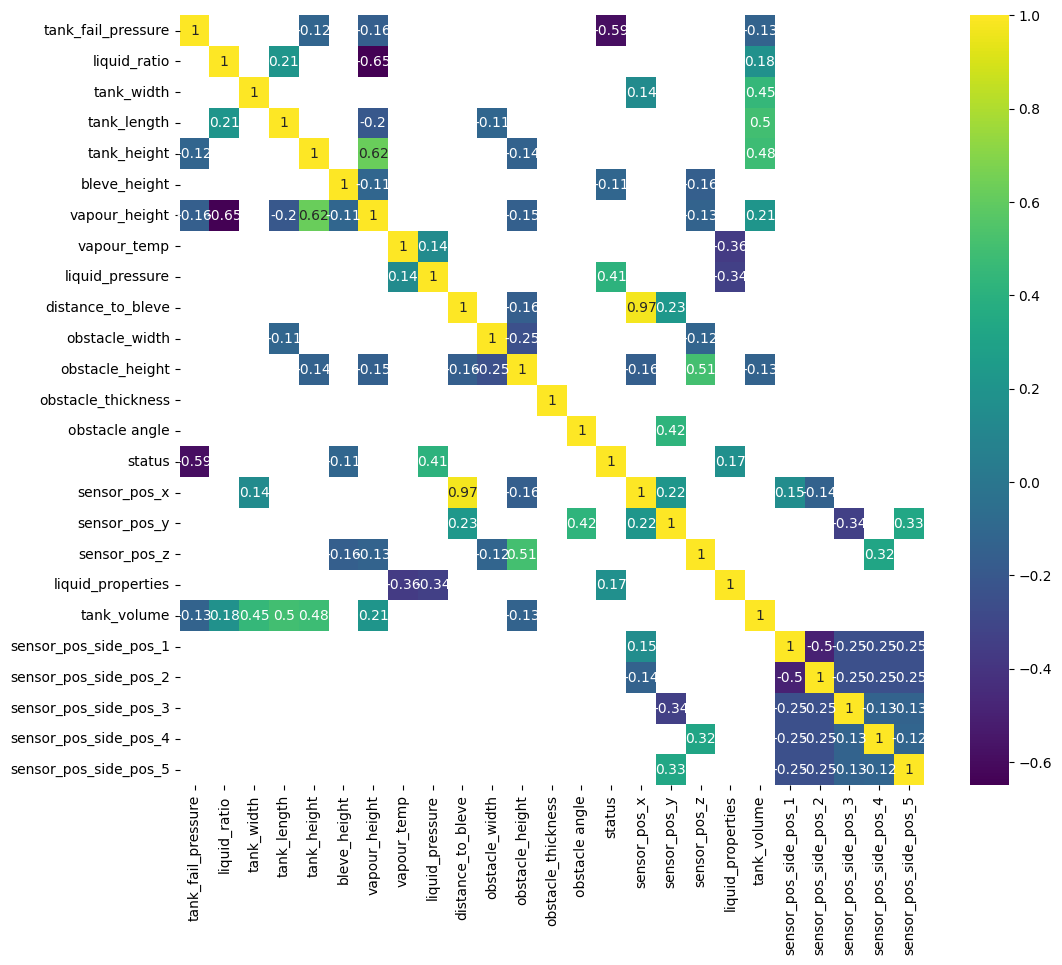

In [352]:
# check for correlation between features -> sensor_pos_x and distance_to_bleve?

import matplotlib.pyplot as plt
import seaborn as sns

def get_corr_plot(data, threshold = 0.5):
    corr = data.corr().round(2)
    mask = abs(corr) > threshold
    corr_filtered = corr[mask]
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_filtered, annot=True, cmap="viridis")

get_corr_plot(X_train, 0.1)

In [ ]:
X_train.corrwith(y_train).sort_values(ascending=False)

sensor_pos_side_pos_2    0.489373
tank_volume              0.284020
vapour_height            0.273402
tank_height              0.200363
tank_length              0.160147
tank_fail_pressure       0.073102
liquid_pressure          0.059123
tank_width               0.051853
liquid_properties        0.051344
sensor_pos_side_pos_3    0.039262
status                   0.022555
vapour_temp             -0.002528
obstacle_thickness      -0.019674
obstacle angle          -0.026727
bleve_height            -0.062902
obstacle_width          -0.071517
obstacle_height         -0.106180
sensor_pos_side_pos_4   -0.106904
sensor_pos_side_pos_5   -0.129107
liquid_ratio            -0.138485
sensor_pos_y            -0.185116
sensor_pos_z            -0.191268
distance_to_bleve       -0.208491
sensor_pos_x            -0.283257
sensor_pos_side_pos_1   -0.359055
dtype: float64

In [353]:
bleve_data = pd.concat([X_train, X_test], axis=0)
bleve_target = pd.concat([y_train, y_test], axis=0)

# Model 1: Support Vector Regression

In [75]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import random
from random import randint


def svr_objective(trial, X_train, y_train):

    """
    Optuna objective function for SVR model that performs cv across outer k-fold, determining
    reduced feature set using RandomForest (assumed non-linearity?). Attempt to
    cover more of the feature space by initially using random selection for
    kernel type and number of features, then let optuna optimize for the rest of
    trials. Returns MAPE across inner 5-fold cv as objective to minimize.

    input parameters:
        trial (Optuna): trial object that stores assigned hyper-parameters and
        result
        X_train (df): outer k-fold features to perform optimization on
        y_train (df): outer k-fold target to perform prediction on for test
        metric

    returns:
        avg_mape (float): average MAPE across all k-folds: used as objective to minimize
    """

    inner_cv = KFold(5, shuffle = True)

    if trial.number <= 25:
        k_features = randint(1, len(X_train.columns))
        kernel = random.choice(["linear", "poly", "rbf", "sigmoid"])
    else:
        k_features = trial.suggest_int("k_features", 1, len(X_train.columns))
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])

    rf = RandomForestRegressor(n_estimators = 200)
    rf.fit(X_train, y_train)

    ordered_feature_importance = np.argsort(rf.feature_importances_)
    selected_features = X_train.columns[ordered_feature_importance[:k_features]]

    X_train_subset = X_train[selected_features]

    svr_params = {
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "epsilon": trial.suggest_float("epsilon", 1e-3, 1, log=True),
        "kernel": kernel,
        "cache_size": 1000,
    }

    # Add the specific parameters based on the kernel type
    if svr_params["kernel"] == "poly":
        svr_params["degree"] = trial.suggest_int("degree", 1, 6)
    if svr_params["kernel"] == "rbf":
        svr_params["gamma"] = trial.suggest_float("gamma", 1e-3, 1, log=True)

    svr_pipeline = make_pipeline(
        StandardScaler(),
        PowerTransformer(),
        SVR(**svr_params)
    )

    mape_fold = cross_val_score(svr_pipeline,
                                  X_train_subset,
                                  y_train,
                                  cv=inner_cv,
                                  scoring="neg_mean_absolute_percentage_error",
                                  n_jobs=-1)

    avg_mape = -np.mean(mape_fold)
    trial.set_user_attr("pipeline", svr_pipeline)
    trial.set_user_attr("selected_features", selected_features)
    trial.set_user_attr("k_features", k_features)
    trial.set_user_attr("kernel", kernel)

    return avg_mape


In [76]:
def all_trial_features(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params} with kernel: {trial.user_attrs['kernel']}.")
    print(f"Best trial so far: {study.best_trial.number}")

In [77]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 12.2 MB/s eta 0:00:00


In [78]:
import optuna
from optuna.pruners import MedianPruner

from sklearn.metrics import mean_absolute_percentage_error, r2_score

svr_scores = []
best_score = np.inf
best_trial = None

fold_num = 1
total_folds = 5

outer_cv = KFold(total_folds, shuffle = True)

optuna.logging.set_verbosity(optuna.logging.WARNING)

for train_idx, val_idx in outer_cv.split(X_train):

    """
    outer k-fold iteration to validate hyper-parameter / feature selection. Uses
    an optuna trial combined with RandomForestRegressor to optimize both. The
    MAPE and R^2 score is then calculated and the best hyper-parameters and
    feature subset are stored for later use.
    """

    print(f"BEGINNING FOLD {fold_num} OF {total_folds}..... \n===============================================")

    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    svr_study = optuna.create_study(direction = "minimize",
                                    pruner = MedianPruner())

    svr_study.optimize(lambda trial: svr_objective(trial, X_train_fold, y_train_fold),
                       n_trials=1,
                       n_jobs=-1,
                       callbacks = [all_trial_features])

    best_model = svr_study.best_trial.user_attrs["pipeline"]
    best_features = svr_study.best_trial.user_attrs["selected_features"]

    best_model.fit(X_train_fold[best_features], y_train_fold)

    mape_fold = mean_absolute_percentage_error(y_val_fold, best_model.predict(X_val_fold[best_features]))
    r2_fold = r2_score(y_val_fold, best_model.predict(X_val_fold[best_features]))

    test_mape = mean_absolute_percentage_error(y_test, best_model.predict(X_test[best_features]))
    test_r2 = r2_score(y_test, best_model.predict(X_test[best_features]))

    mean_mape = (mape_fold + test_mape) / 2
    mean_r2 = (r2_fold + test_r2) / 2

    print(f"best fold mape: {round(mean_mape, 4)}, best fold r2: {round(mean_r2, 4)}")

    svr_scores.append(mean_mape)

    if mean_mape < best_score:
        best_score = mean_mape
        best_trial = svr_study.best_trial

    print(f"CURRENT BEST SCORE: {round(best_score, 4)}")

    fold_num += 1

best_final_svr_model = best_trial.user_attrs["pipeline"]
best_final_svr_features = best_trial.user_attrs["selected_features"]

BEGINNING FOLD 1 OF 5..... 
Trial 0 finished with value: 1.7165272687664035 and parameters: {'C': 203.33890612880123, 'epsilon': 0.16796779861164776, 'gamma': 0.5849829621349892} with kernel: rbf.
Best trial so far: 0
best fold mape: 1.5988, best fold r2: 0.714
CURRENT BEST SCORE: 1.5988
BEGINNING FOLD 2 OF 5..... 
Trial 0 finished with value: 8667.74032484766 and parameters: {'C': 314.4875339960396, 'epsilon': 0.8805896523778084} with kernel: sigmoid.
Best trial so far: 0
best fold mape: 11534.2802, best fold r2: -17827008.3572
CURRENT BEST SCORE: 1.5988
BEGINNING FOLD 3 OF 5..... 
Trial 0 finished with value: 0.5371476424519095 and parameters: {'C': 0.06719336590078293, 'epsilon': 0.0021115775874662344, 'gamma': 0.07964618633053736} with kernel: rbf.
Best trial so far: 0
best fold mape: 0.5389, best fold r2: 0.1725
CURRENT BEST SCORE: 0.5389
BEGINNING FOLD 4 OF 5..... 
Trial 0 finished with value: 64.5781940467264 and parameters: {'C': 1.5855264538369, 'epsilon': 0.3705219886424615} 

In [ ]:
import pickle

with open("best_svr_model.pkl", "wb") as f:
    pickle.dump(best_final_svr_model, f)

In [79]:
best_final_svr_model.fit(bleve_data[best_final_svr_features], bleve_target)
test_pred = best_final_svr_model.predict(test_sample[best_final_svr_features])

y_pred_df = pd.DataFrame({
    "ID": range(0, len(test_pred)),
    "Target Pressure (bar)": test_pred
})
y_pred_df.to_csv("submission.csv", index=False)

# Model 2: XGBoost

In [272]:
import xgboost as xgb

def xg_objective(trial, X_train, y_train):

    """
    Optuna objective function for XGBoost model that performs cv across outer
    k-fold. XGBoost automatically selects features so additional feature
    selection step is not needed. Returns MAPE across inner 5-fold cv as objective to minimize.

    input parameters:
        trial (Optuna): trial object that stores assigned hyper-parameters and
        result
        X_train (df): outer k-fold features to perform optimization on
        y_train (df): outer k-fold target to perform prediction on for test metric

    returns:
        avg_mape (float): average MAPE across all k-folds: used as objective to minimize
    """

    d_train = xgb.DMatrix(data = X_train, label = y_train)

    param = {
        "verbosity": 1,
        "objective": "reg:absoluteerror",
        "eval_metric": "mape",
        "device": "cuda",
        "booster": "gbtree",
        "eta": trial.suggest_float("eta", 1e-2, 0.5, log = True),
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "subsample": trial.suggest_float("subsample", 0.1, 0.9),
        "sampling_method": "gradient_based",
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
        "lambda": trial.suggest_float("lambda", 0.1, 40.0),
        "alpha": trial.suggest_float("alpha", 0.1, 40.0),
        "tree_method": "hist",
    }

    num_boost_rounds = trial.suggest_int("num_boost_rounds", 100, 500)

    pruning_cb = optuna.integration.XGBoostPruningCallback(trial, "test-mape")

    xg_cv = xgb.cv(param,
                    d_train,
                    nfold = 5,
                    metrics="mape",
                    num_boost_round = num_boost_rounds,
                    callbacks = [pruning_cb])

    avg_mape = xg_cv["test-mape-mean"].values[-1]
    xg_model = xgb.train(param,
                         d_train,
                         num_boost_round = num_boost_rounds)

    trial.set_user_attr("pipeline", xg_model)
    return avg_mape



In [85]:
!pip install optuna_integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 1.3 MB/s eta 0:00:00


In [275]:
xg_scores = []
best_score = np.inf
best_trial = None

fold_num = 1
total_folds = 5

outer_cv = KFold(total_folds, shuffle = True)

d_test = xgb.DMatrix(data = X_test, label = y_test)

for train_idx, val_idx in outer_cv.split(X_train):

    print(f"BEGINNING FOLD {fold_num} OF {total_folds}..... \n===============================================")

    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xg_study = optuna.create_study(direction = "minimize",
                                    pruner = MedianPruner())

    xg_study.optimize(lambda trial: xg_objective(trial, X_train_fold, y_train_fold),
                       n_trials=1,
                       n_jobs=-1)

    best_model = xg_study.best_trial.user_attrs["pipeline"]

    d_train = xgb.DMatrix(data = X_train_fold, label = y_train_fold)
    d_val = xgb.DMatrix(data = X_val_fold, label = y_val_fold)

    mape_fold = mean_absolute_percentage_error(y_val_fold, best_model.predict(d_val))
    r2_fold = r2_score(y_val_fold, best_model.predict(d_val))

    test_mape = mean_absolute_percentage_error(y_test, best_model.predict(d_test))
    test_r2 = r2_score(y_test, best_model.predict(d_test))

    mean_mape = (mape_fold + test_mape) / 2
    mean_r2 = (r2_fold + test_r2) / 2

    print(f"best fold mape: {round(mean_mape, 4)}, best fold r2: {round(mean_r2, 4)}")

    xg_scores.append(mean_mape)

    if mean_mape < best_score:
        best_xg_score = mean_mape
        best_xg_trial = xg_study.best_trial

    print(f"CURRENT BEST SCORE: {round(best_xg_score, 4)}")

    fold_num += 1

best_final_xg_model = best_xg_trial.user_attrs["pipeline"]

BEGINNING FOLD 1 OF 5..... 
best fold mape: 0.2003, best fold r2: 0.7044
CURRENT BEST SCORE: 0.2003
BEGINNING FOLD 2 OF 5..... 
best fold mape: 0.1785, best fold r2: 0.866
CURRENT BEST SCORE: 0.1785
BEGINNING FOLD 3 OF 5..... 
best fold mape: 0.1785, best fold r2: 0.8443
CURRENT BEST SCORE: 0.1785
BEGINNING FOLD 4 OF 5..... 
best fold mape: 0.1782, best fold r2: 0.7662
CURRENT BEST SCORE: 0.1782
BEGINNING FOLD 5 OF 5..... 
best fold mape: 0.2224, best fold r2: 0.6727
CURRENT BEST SCORE: 0.2224


In [277]:
from xgboost import XGBRegressor

best_params = {
        "verbosity": 1,
        "objective": "reg:absoluteerror",
        "eval_metric": "mape",
        "device": "cuda",
        "booster": "gbtree",
        "eta": best_xg_trial.params["eta"],
        "max_depth": best_xg_trial.params["max_depth"],
        "subsample": best_xg_trial.params["subsample"],
        "sampling_method": "gradient_based",
        "min_child_weight": best_xg_trial.params["min_child_weight"],
        "lambda": best_xg_trial.params["lambda"],
        "alpha": best_xg_trial.params["alpha"],
        "tree_method": "hist",
        "n_estimators": best_xg_trial.params["num_boost_rounds"]
    }

xg_best = XGBRegressor(**best_params)
xg_best.fit(bleve_data, bleve_target)

XGBRegressor(alpha=22.151747583610312, base_score=None, booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eta=0.056488755925189746,
             eval_metric='mape', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=34.33442003388629,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=32, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=480, ...)

In [280]:
d_sample = xgb.DMatrix(data = test_sample)

test_pred = best_final_xg_model.predict(d_sample)

y_pred_df = pd.DataFrame({
    "ID": range(0, len(test_pred)),
    "Target Pressure (bar)": test_pred
})
y_pred_df.to_csv("submission.csv", index=False)

# Model 3: ANN

In [ ]:
from sklearn.neural_network import MLPRegressor

def mlp_objective(trial, X_train, y_train):

    """
    Optuna objective function for SVR model that performs cv across outer k-fold, determining
    reduced feature set using RandomForest (assumed non-linearity?). Attempt to
    cover more of the feature space by initially using random selection for
    number of features, then let optuna optimize for the rest of
    trials. Returns MAPE across inner 5-fold cv as objective to minimize.

    input parameters:
        trial (Optuna): trial object that stores assigned hyper-parameters and
        result
        X_train (df): outer k-fold features to perform optimization on
        y_train (df): outer k-fold target to perform prediction on for test
        metric

    returns:
        avg_mape (float): average MAPE across all k-folds: used as objective to minimize
    """

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    if trial.number <= 25:
        k_features = randint(1, len(X_train.columns))
    else:
        k_features = trial.suggest_int("k_features", 1, len(X_train.columns))

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    ordered_feature_importance = np.argsort(rf.feature_importances_)
    selected_features = X_train.columns[ordered_feature_importance[:k_features]]

    X_train_subset = X_train[selected_features]

    num_hidden = trial.suggest_int("num_hidden", 1, 5)

    layers = []

    for layer in range(num_hidden):
        layers.append(trial.suggest_int(f"h_layer_{layer}_size", 32, 1024, log=True))

    activation = trial.suggest_categorical("activation", ["identity", "logistic", "tanh", "relu"])
    solver = trial.suggest_categorical("solver", ["sgd", "adam"])
    alpha = trial.suggest_float("alpha", 0.0001, 0.1, log=True)
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])

    mlp_pipeline = make_pipeline(
        StandardScaler(),
        PowerTransformer(),
        MLPRegressor(
            hidden_layer_sizes=tuple(layers),
            activation=activation,
            solver=solver,
            alpha=alpha,
            learning_rate=learning_rate,
            random_state=42,
            max_iter=500,
        )
    )

    mape_fold = cross_val_score(
        mlp_pipeline,
        X_train_subset,
        y_train,
        cv=inner_cv,
        scoring="neg_mean_absolute_percentage_error",
        n_jobs=-1
    )
    avg_mape = -np.mean(mape_fold)

    trial.set_user_attr("pipeline", mlp_pipeline)
    trial.set_user_attr("selected_features", selected_features)
    trial.set_user_attr("k_features", k_features)

    return avg_mape

In [ ]:
import optuna
from optuna.pruners import MedianPruner

from sklearn.metrics import mean_absolute_percentage_error, r2_score

mlp_scores = []
best_score = np.inf
best_trial = None

fold_num = 1
total_folds = 5

outer_cv = KFold(total_folds, shuffle = True)

for train_idx, val_idx in outer_cv.split(X_train):

    print(f"BEGINNING FOLD {fold_num} OF {total_folds}..... \n===============================================")

    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    mlp_study = optuna.create_study(direction = "minimize",
                                    pruner = MedianPruner())

    mlp_study.optimize(lambda trial: mlp_objective(trial, X_train_fold, y_train_fold),
                       n_trials=50,
                       n_jobs=-1)

    best_model_fold = mlp_study.best_trial.user_attrs["pipeline"]
    best_features = mlp_study.best_trial.user_attrs["selected_features"]

    best_model_fold.fit(X_train_fold[best_features], y_train_fold)
    mape_fold = mean_absolute_percentage_error(y_val_fold, best_model_fold.predict(X_val_fold[best_features]))
    r2_fold = r2_score(y_val_fold, best_model_fold.predict(X_val_fold[best_features]))

    test_mape = mean_absolute_percentage_error(y_test, best_model_fold.predict(X_test[best_features]))
    test_r2 = r2_score(y_test, best_model_fold.predict(X_test[best_features]))

    mean_mape = (mape_fold + test_mape) / 2
    mean_r2 = (r2_fold + test_r2) / 2

    print(f"best fold mape: {round(mean_mape, 4)}, best fold r2: {round(mean_r2, 4)}")

    mlp_scores.append(mean_mape)

    if mean_mape < best_score:
        best_score = mean_mape
        best_trial = mlp_study.best_trial

    print(f"CURRENT BEST SCORE: {round(best_score, 4)}")

    fold_num += 1

best_final_model = best_trial.user_attrs["pipeline"]
best_final_features = best_trial.user_attrs["selected_features"]

[I 2024-05-06 11:07:36,650] Trial 33 finished with value: 0.8748706184794234 and parameters: {'k_features': 12, 'num_hidden': 2, 'h_layer_0_size': 106, 'h_layer_1_size': 99, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.001078602523337971, 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.33878076000925583.
[I 2024-05-06 11:08:01,965] Trial 26 finished with value: 0.45940207266308847 and parameters: {'k_features': 9, 'num_hidden': 4, 'h_layer_0_size': 36, 'h_layer_1_size': 233, 'h_layer_2_size': 279, 'h_layer_3_size': 789, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0008049815432517533, 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.33878076000925583.
[I 2024-05-06 11:08:10,338] Trial 32 finished with value: 0.49882317929062064 and parameters: {'k_features': 15, 'num_hidden': 2, 'h_layer_0_size': 279, 'h_layer_1_size': 97, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0008185232168875441, 'learning_rate': 'adaptive'}. Best is trial 1 with

mape: 0.26194438195571934, r2: 0.9281786574264417
CURRENT BEST SCORE: 0.1641
BEGINNING FOLD 5 OF 5..... 


[I 2024-05-06 11:12:41,303] Trial 0 finished with value: 1.217188778293526 and parameters: {'num_hidden': 1, 'h_layer_0_size': 212, 'activation': 'identity', 'solver': 'adam', 'alpha': 0.018680958258570354, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 1.217188778293526.
[I 2024-05-06 11:12:48,736] Trial 6 finished with value: 1.8141149350915242 and parameters: {'num_hidden': 1, 'h_layer_0_size': 271, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0003296809251614521, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 1.217188778293526.
[I 2024-05-06 11:13:33,104] Trial 2 finished with value: 0.43096860953114013 and parameters: {'num_hidden': 3, 'h_layer_0_size': 214, 'h_layer_1_size': 164, 'h_layer_2_size': 238, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.019157289918325864, 'learning_rate': 'invscaling'}. Best is trial 2 with value: 0.43096860953114013.
[I 2024-05-06 11:13:50,000] Trial 7 finished with value: 1.8722631312878744 and parameters: {'num_h

mape: 0.18701969754302383, r2: 0.9567861027054894
CURRENT BEST SCORE: 0.1641


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
best_final_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('powertransformer', PowerTransformer()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.0006446347182762546,
                              hidden_layer_sizes=(185, 382, 391, 74),
                              learning_rate='adaptive', max_iter=500,
                              random_state=42))])

In [52]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

ordered_feature_importance = np.argsort(rf.feature_importances_)
selected_features = X_train.columns[ordered_feature_importance[:24]]

In [53]:
best_final_features = selected_features

In [ ]:
import pickle

with open("best_mlp_model.pkl", "wb") as f:
    pickle.dump(best_final_model, f)

In [214]:
import pickle

with open("best_mlp_model.pkl", "rb") as f:
    best_final_model = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PowerTransformer from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For mo

In [215]:
best_final_model.fit(bleve_data[best_final_features], bleve_target)
test_pred = best_final_model.predict(test_sample[best_final_features])

y_pred_df = pd.DataFrame({
    "ID": range(0, len(test_pred)),
    "Target Pressure (bar)": test_pred
})
y_pred_df.to_csv("submission.csv", index=False)

# Explainability Analysis

In [56]:
best_final_model.fit(X_train[best_final_features], y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('powertransformer', PowerTransformer()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.0006446347182762546,
                              hidden_layer_sizes=(185, 382, 391, 74),
                              learning_rate='adaptive', max_iter=500,
                              random_state=42))])

In [354]:
# shap can't directly handle the established pipeline as the result is a numpy
# array, so we first need to transform the features for analysis

power_transformer = best_final_model.named_steps['powertransformer']
scaler = best_final_model.named_steps['standardscaler']

In [355]:
X_train_scaled = scaler.transform(X_train[best_final_features])
X_train_transformed = power_transformer.transform(X_train_scaled)
X_train_preprocessed = pd.DataFrame(X_train_transformed, columns=X_train[best_final_features].columns)

In [356]:
X_test_scaled = scaler.transform(X_test[best_final_features])
X_test_transformed = power_transformer.transform(X_test_scaled)
X_test_preprocessed = pd.DataFrame(X_test_transformed, columns=X_test[best_final_features].columns)

In [358]:
from sklearn.neural_network import MLPRegressor

params = {
    "alpha": 0.0006446347182762546,
    "hidden_layer_sizes": (185, 382, 391, 74),
    "learning_rate": "adaptive",
    "max_iter": 500,
}

model = MLPRegressor(**params)
model.fit(X_train_preprocessed, y_train)

MLPRegressor(alpha=0.0006446347182762546,
             hidden_layer_sizes=(185, 382, 391, 74), learning_rate='adaptive',
             max_iter=500)

In [426]:
# randomly sample from training and test datasets to decrease computational load: assessing over all 7000 training and 3000 test is not feasible

num_samples = 500

X_train = X_train.reset_index(drop=True)
X_train_subset = X_train[best_final_features]

sampled_indices = X_train_subset.sample(num_samples, random_state=RANDOM_SEED).index
y_train_sample = y_train.iloc[sampled_indices]
y_train_sample = y_train_sample.reset_index(drop=True)
X_train_sample = X_train_subset.iloc[sampled_indices]
X_train_sample_preprocessed = X_train_preprocessed.iloc[sampled_indices]
X_train_sample = X_train_sample.reset_index(drop=True)

In [427]:
num_samples = 100

X_test = X_test.reset_index(drop=True)
X_test_subset = X_test[best_final_features]

sampled_indices = X_test_subset.sample(num_samples, random_state=RANDOM_SEED).index
y_test_sample = y_test.iloc[sampled_indices]
y_test_sample = y_test_sample.reset_index(drop=True)
X_test_sample = X_test_subset.iloc[sampled_indices]
X_test_sample_preprocessed = X_test_preprocessed.iloc[sampled_indices]
X_test_sample = X_test_sample.reset_index(drop=True)

In [428]:
y_pred = model.predict(X_test_sample_preprocessed)

In [431]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train_sample_preprocessed)

In [432]:
shap_values = explainer.shap_values(X_test_sample_preprocessed)

  0%|          | 0/100 [00:00<?, ?it/s]

In [403]:
with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)

In [ ]:
with open("explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

In [433]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test_sample)

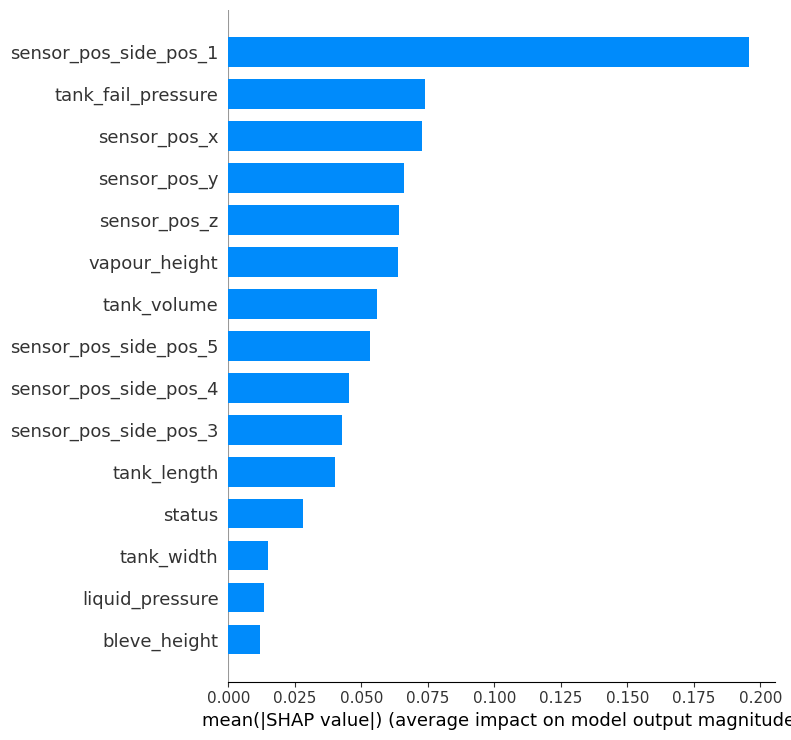

In [434]:
shap.initjs()
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", max_display = 15)

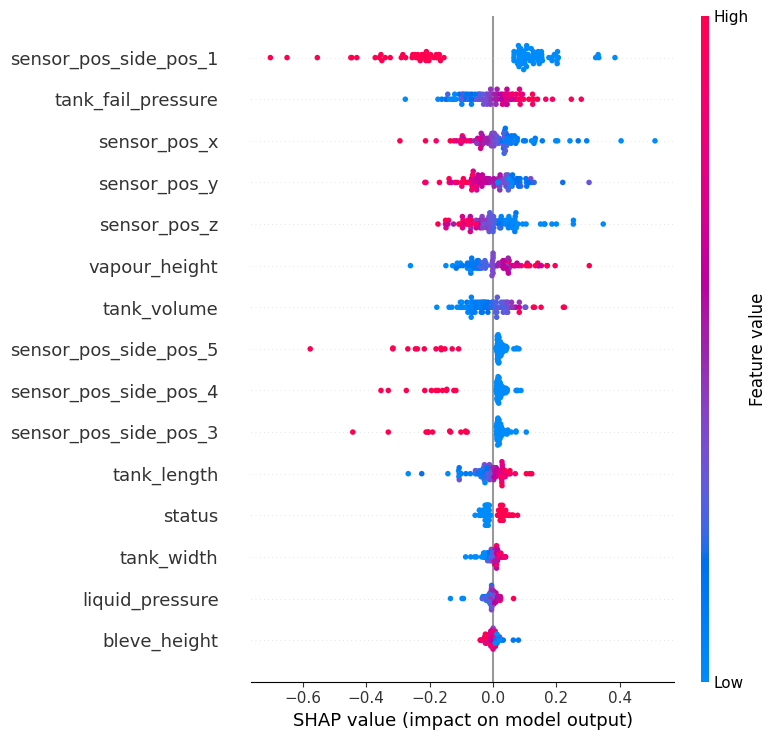

In [435]:
shap.initjs()
shap.summary_plot(shap_values, X_test_sample, max_display = 15)

Conclusions:
- Top 10 features signficantly more influential. Tank failure pressure has expected increase in prediction for higher values (more powerful BLEVE released)
- all sensor pos encoded categoricals have shrinking effect when true ("higher" value). Tank volume, width, vapour height and tank length all have shrinking effect at higher values

In [436]:
y_pred.argmax()

77

In [437]:
shap_values.shape

(100, 24)

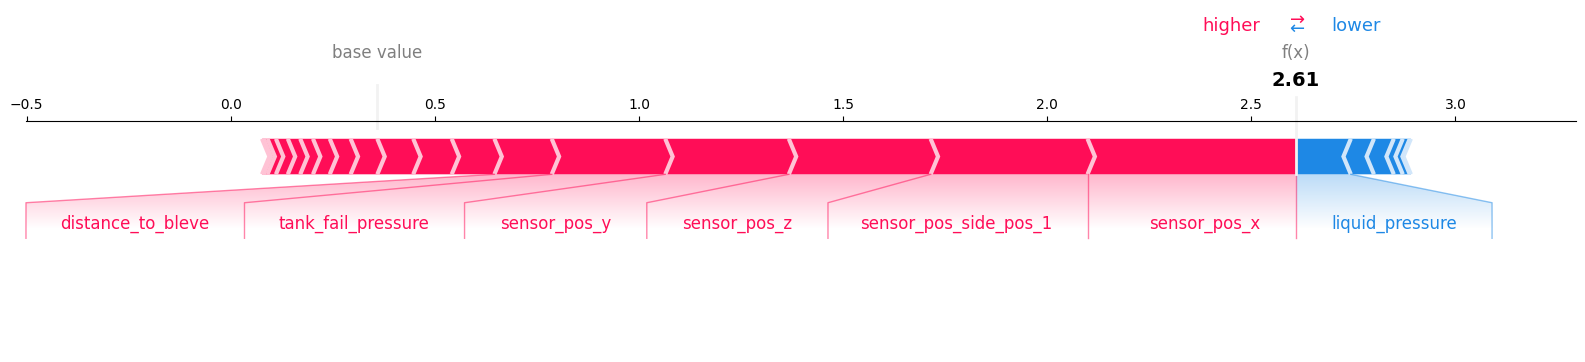

In [439]:
# check force plot for highest prediction

shap.initjs()
max_idx = y_pred.argmax()
max_shap = shap_values[max_idx]

shap.plots.force(explainer.expected_value, max_shap, feature_names=X_test_sample.columns, matplotlib=True)

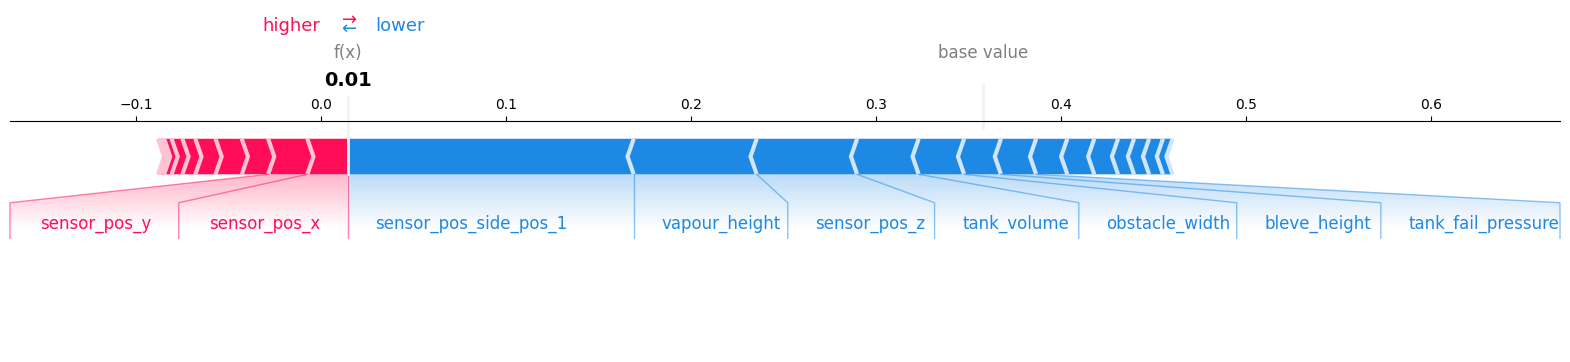

In [440]:
# check force plot for lowest prediction

shap.initjs()
min_idx = y_pred.argmin()
min_shap = shap_values[min_idx]
shap.plots.force(explainer.expected_value, min_shap, feature_names=X_test_sample.columns, matplotlib=True)

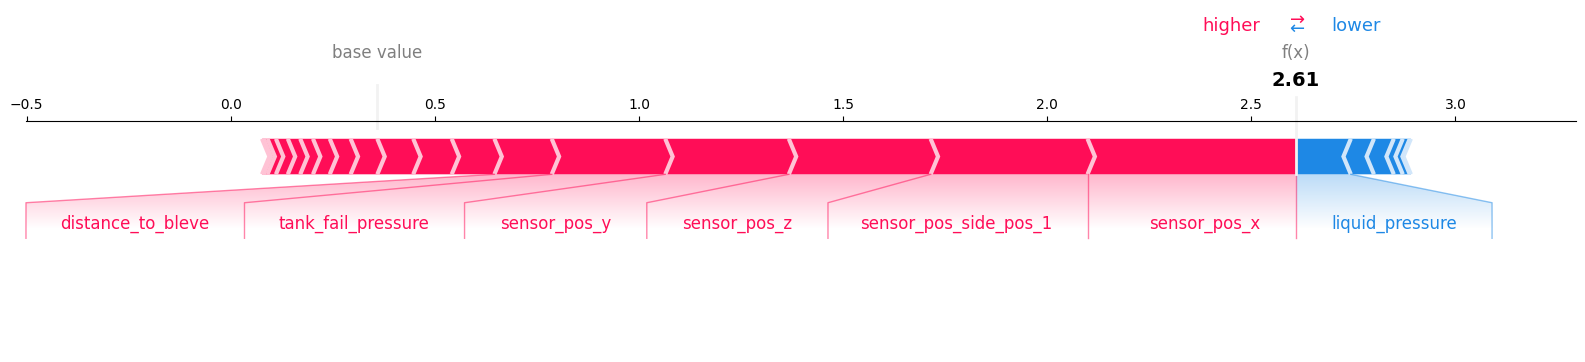

In [441]:
# check force plot for worst prediction

pred_error = abs(y_pred - y_test_sample)
max_error_idx = pred_error.argmax()

max_error_shap = shap_values[max_error_idx]
shap.plots.force(explainer.expected_value, max_error_shap, feature_names=X_test_sample.columns, matplotlib=True)

Conclusions:
- Both highest prediction and highest predicted error are the same prediction, suggesting that overall the model tends to overestimate the target variate
- Sensor_pos_1 has a significant impact in both cases. For the high prediction, it boosts the model prediction and for the lowest shrinks it. Whilst not explicity defined we suggest that this position denotes a sensor that is located farthest from the BLEVE origin point, and hence is most affected by the origin strength
- The sensor xyz coordinates are also strong influencers, acting to boost the prediction
- Tank failure pressure and distance to bleve are the final main boosting features. This makes sense, the failure pressure denotes how likely the container holding the volatile substance is to rupture, and hence the BLEVE strength, and distance to bleve determines how much energy remains in the blast wave
- For the highest prediction liquid_pressure is the main shrinkage feature. This again is logical given the scenario: a volatile substance at low pressure will result in a much weaker blast compared to one at higher pressure
- For the lowest recorded prediction, the main shrinkage factor (aside from previously mentioned) is the vapour height, container volume, obstacle width and bleve height. The two heights act to determine how much volume the blast wave will propogate throughout, so if they are large, the energy will be potentially spread out over a larger area. Container volume is explicit: a larger container will result in the same effect. Finally, obstacle width determines how much energy is absorbed before being recorded by the sensors

INFO:PyALE._ALE_generic:Discrete feature detected.


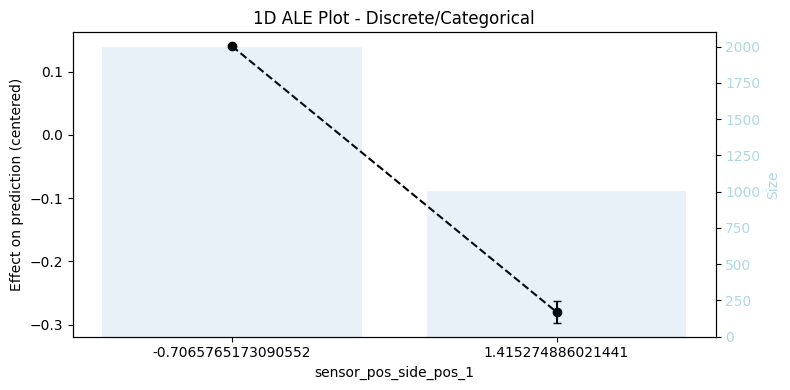

In [450]:
from PyALE import ale

ale_eff = ale(
    X=X_test_preprocessed[best_final_features], model=model, feature=["sensor_pos_side_pos_1"], grid_size=50, include_CI=True, C=0.95
)

INFO:PyALE._ALE_generic:Continuous feature detected.


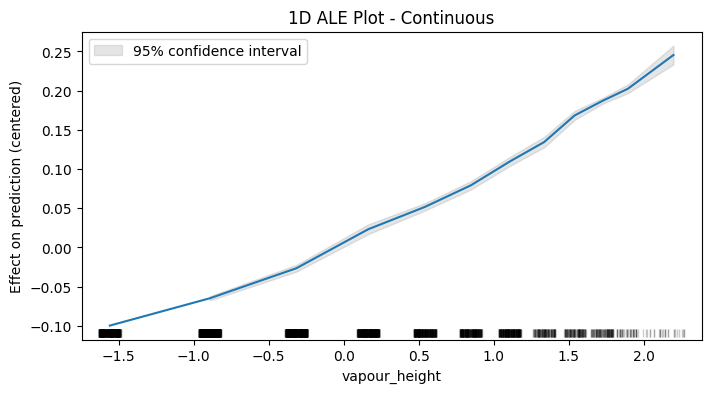

In [452]:
from PyALE import ale

ale_eff = ale(
    X=X_test_preprocessed[best_final_features], model=model, feature=["vapour_height"], grid_size=50, include_CI=True, C=0.95
)

INFO:PyALE._ALE_generic:Continuous feature detected.


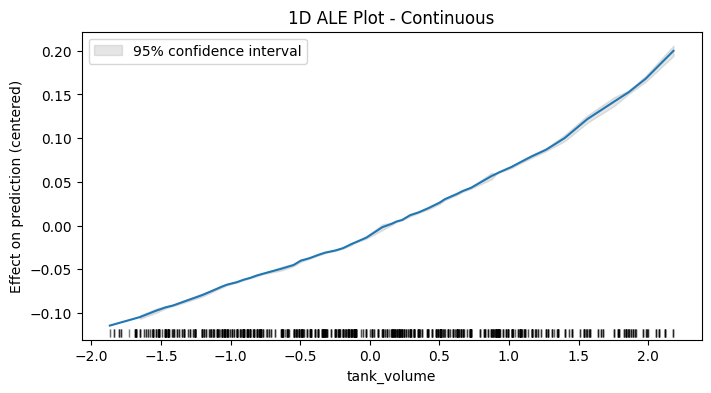

In [453]:
ale_eff = ale(
    X=X_test_preprocessed, model=model, feature=["tank_volume"], grid_size=50, include_CI=True, C=0.95
)

INFO:PyALE._ALE_generic:Continuous feature detected.


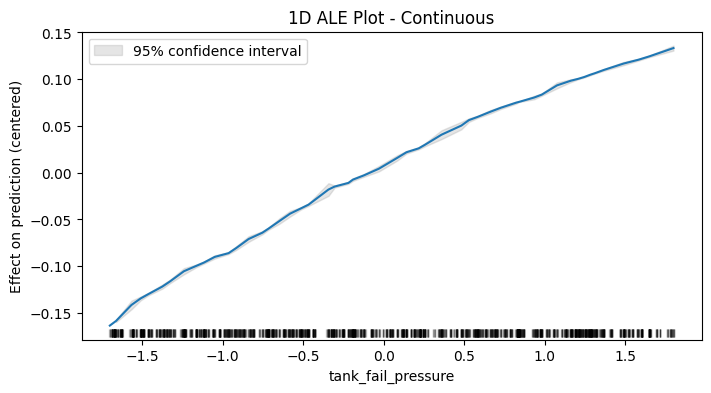

In [454]:
ale_eff = ale(
    X=X_test_preprocessed, model=model, feature=["tank_fail_pressure"], grid_size=50, include_CI=True, C=0.95
)

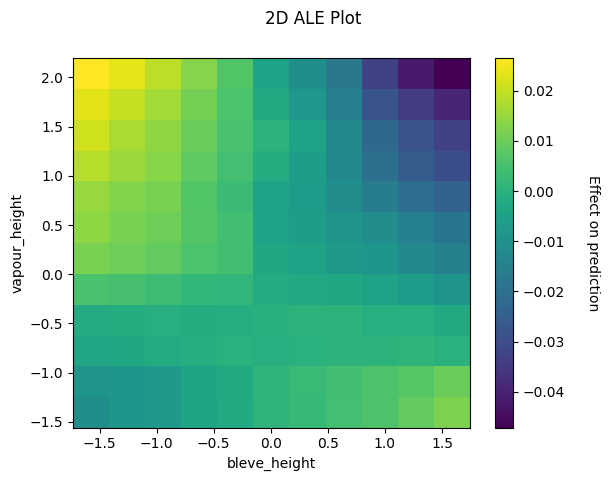

In [455]:
ale_eff = ale(
    X=X_test_preprocessed, model=model, feature=["vapour_height", "bleve_height"], grid_size=100, include_CI=True, C=0.95
)

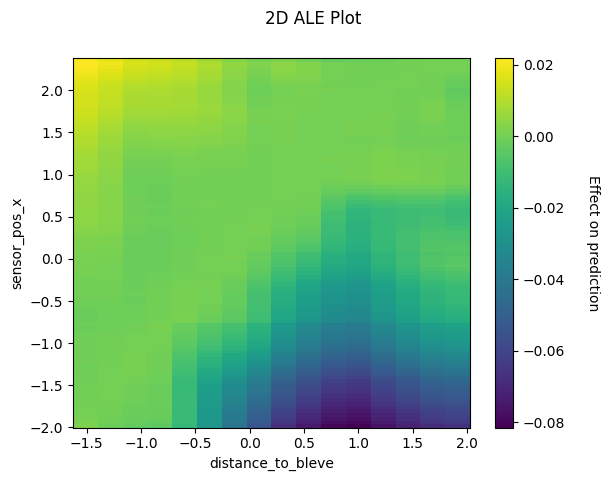

In [456]:
ale_eff = ale(
    X=X_test_preprocessed, model=model, feature=["sensor_pos_x", "distance_to_bleve"], grid_size=100, include_CI=True, C=0.95
)

Conclusions:
- strong positive pseudo-linear relationship with continuous features
- vapour height has a slightly larger variance, potentially more unstable for feature prediction?
- when the sensor isn't in position one (assumed farthest) prediction is higher, again supporting this theory. If the sensor is further away the expected energy should be lower as the BLEVE has travelled further
- (somewhat) inverse relationship between vapour and bleve height. If both are high, the resulting blast wave will be spread out more, reducing the recorded energy. Conversely, if the bleve height is low but the vapour high the energy will be more concentrated, resulting in a higher reading
- high correlation between sensor x coordinate and bleve distance, proving that they are effectively measuring the same thing. drop from future investigations?